#  Density Estimation
-------------------------------------------------------
## Pablo de Castro (INFN - Sezione di Padova)

   
## Statistics and Data Analysis course exam
   

## XXXI Physics PhD cycle - University of Padova

This presentation is also a Jupyter notebook document, which
mixes the material shown here with the correspoing code used
to generate the examples and figures. All of that is available
at the following repository:

[https://github.com/pablodecm/density_estimation](https://github.com/pablodecm/density_estimation)


In [224]:
!date +%d\ %B\ %G

04 October 2016


# Contents

* [Problem description](#Problem-description)
* [Benchmark datasets](#Benchmark-datasets)
* [Bias, variance and loss functions](#Bias,-variance-and-loss-functions)
* [Confidence intervals and bands](#Confidence-intervals-and-bands)
* [Histograms as density estimators](#Histograms-as-density-estimators)
* [Nearest neighbor density estimation](#Nearest-neighbor-density-estimation)
* [Kernel density estimation](#Kernel-density-estimation)
* [Additional interesting stuff on density estimation](#Additional-interesting-stuff-on-density-estimation)
* [Conclusions](#Conclusions)


### Problem description

Given a set of independent and identically distributed observations $\{x_0,...,x_n\}$, we want to estimate the parent probability density function $f(x)$ from where those samples where taken. 

A density estimate $\hat{f}(x)$ of a distribution can have many use cases (e.g. graphical representation, subsequent statistical inference). Methods for density estimation are generally classified in one of this two categories:
* **Parametric**: strong assumptions about the functional form of the *pdf* are made, so the problem is simplified to find the parameters of the function that describe the data.
* **Non-parametric**: sometimes simple functional forms cannot be assumed, so a few assumptions are done and the actual density is estimated directly from the data itself.



#### Use cases  in high energy physics

In the field of  high energy physics, non-parametric density estimation plays
an important role but the popularity of histograms and simple parametrizations
might be causing some non-optimalities in density estimation:

* **Differencial efficiency estimation**: the efficency as a funcion of certain variables
$\vec{x}$ after a certain selection (e.g. trigger) is nothing else but the ratio between
the probability density before and after
$\epsilon(\vec{x})=\frac{f_{\mathrm{after}}(\vec{x})}{f_{\mathrm{before}}(\vec{x})}$.
While this is typically handled using histograms, there are much better alternatives.


#### Use cases  in high energy physics

In the field of  high energy physics, non-parametric density estimation plays
an important role but the popularity of histograms and simple parametrizations
might be causing some non-optimalities in density estimation:

* **Differencial efficiency estimation**
* **Parametrizations for fast detector simulation / Matrix Element Method**: if a detailed probability density can
be estimated for a detector based on a detailed simulation, then it can be used
to have an acurrate fast detector simulation given the initial variables. Also mostly done
with histograms or naive parametrizations nowadays.

#### Use cases  in high energy physics

In the field of  high energy physics, non-parametric density estimation plays
an important role but the popularity of histograms and simple parametrizations
might be causing some non-optimalities in density estimation:

* **Differencial efficiency estimation**
* **Parametrizations for fast detector simulation / Matrix Element Method**
* **Simulation or data based unbinned density**: statistical inference is currently done using
parametric models for unbinned likelihoods or histograms of simulation/data for binned maximum
likelihood. Parametric models are in many cases too simplistic, while histograms do not deal well
with nuissance parameters (e.g. so called template morphing and interpolation). Given large enough
simulated or CR-data samples, an accurrate smooth density estimation $\hat{f}(x)$ where $\vec{x}$ are
the fitting variables could allow to do unbinned inference while properly handling the nuissance
parameters.

#### Why histograms are so popular in HEP?



### Benchmark datasets

A few 1D and 2D examples will be used to benchmark the different methods
considered in this work. They do not aim to represent all the possible class
of problems for which density estimation is useful but only to exemplify the
use of each type of estimator.

In addition to $f(x)$ another important factor to consider is the number
of samples $n$ available, because for consistent estimators $\hat{f}(x)$ converges to 
$f(x)$ as $n\rightarrow \infty$


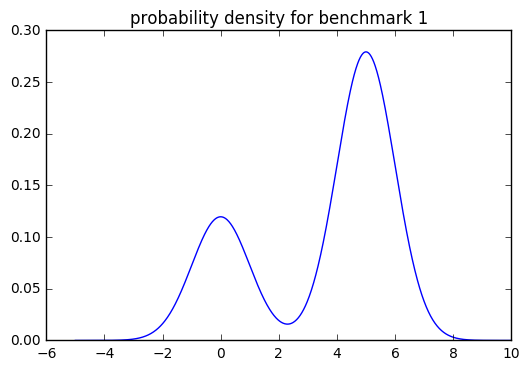

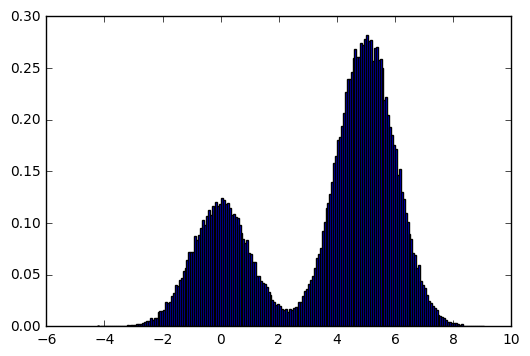

In [124]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

class Mix1DNormalDist:
    """ Class to sammple data for a mixture of Normal distributions in one dimension
    and also provide a function of the underlying model """
    def __init__(self, means, sigmas, rel_fracs):
        self.means = means
        self.sigmas = sigmas
        self.rel_fracs = rel_fracs
    
    def data(self, samples, seed = 1):
        np.random.seed(1)
        normal = np.random.normal
        normal_pars = zip(self.means, self.sigmas, self.rel_fracs)
        return np.concatenate(tuple(normal(m,s,int(np.rint(f*samples)))
                                    for m,s,f in normal_pars))[:, np.newaxis]
    def density(self, X):
        normal_pars = zip(self.means, self.sigmas, self.rel_fracs)
        return sum(tuple(f*norm(m,s).pdf(X) for m,s,f in normal_pars))
      
b1 = Mix1DNormalDist([0,5], [1,1], [0.3, 0.7])
b1_density_f, b1_density_ax = plt.subplots()
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
b1_density_ax.plot(X_plot,b1.density(X_plot));
b1_density_ax.set_title("probability density for benchmark 1")
b1_density_f
b1_hist_f, b1_hist_ax = plt.subplots()
b1_hist_ax.hist(b1.data(100000), 200, normed=True);


#### Benchmark 1 - Mixture of two normal distributions

This is the bimodal *pdf* used in the
[Simple 1D Kernel Density Estimation](http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py) example by Jake Vanderplas and included the [scikit-learn](http://scikit-learn.org/stable/index.html) package. It is composed by two almost non-overlaping normal distributions of different height:

$$ b_1(x) = 0.3 \cdot \mathcal{N}(0,1)(x) + 0.7 \cdot \mathcal{N}(5,1)(x) $$


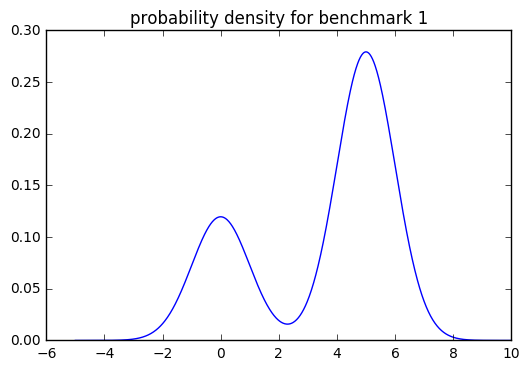

In [125]:
b1_density_f

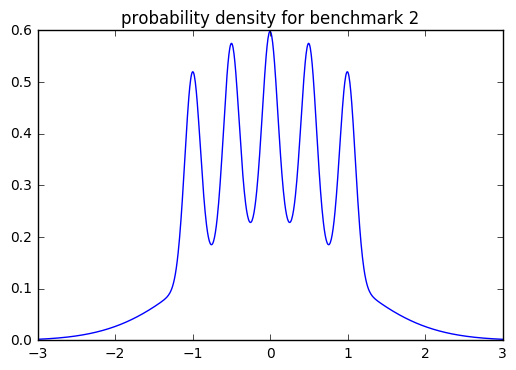

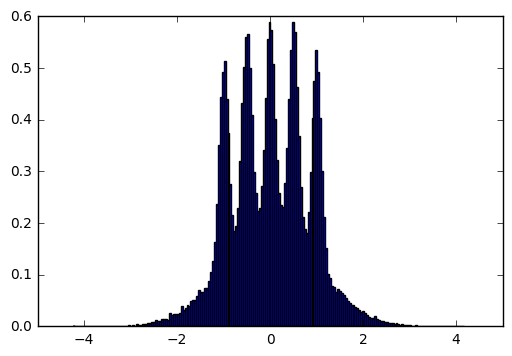

In [128]:
b2 = Mix1DNormalDist([0,-1,-0.5,0,0.5,1],
                     [1,0.1,0.1,0.1,0.1,0.1],
                     [0.5, 0.1,0.1,0.1,0.1,0.1])
b2_density_f, b2_density_ax = plt.subplots()
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
b2_density_ax.plot(X_plot,b2.density(X_plot))
b2_hist_f, b2_hist_ax = plt.subplots()
b2_hist_ax.hist(b2.data(100000), 200, normed=True);
b2_density_ax.set_title("probability density for benchmark 2");

#### Benchmark 2 - Claw (a.k.a. Bart Simpson) density

This *pdf* is also a mixture of several Normal distributions, but in this case they are overlapping and conform a complex multimodal distribution, which was called *Claw density* by [Marron and Wand (1992)](https://projecteuclid.org/euclid.aos/1176348653). It can be analytically expressed as:

$$ b_1(x) = \frac{1}{2} \cdot \mathcal{N}(0,1)(x) + \frac{1}{2} \sum_{j=0}^4 \cdot \mathcal{N}(j/2-1,1/10)(x) $$



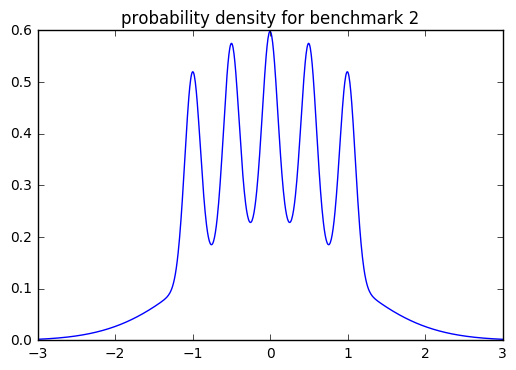

In [127]:
b2_density_f

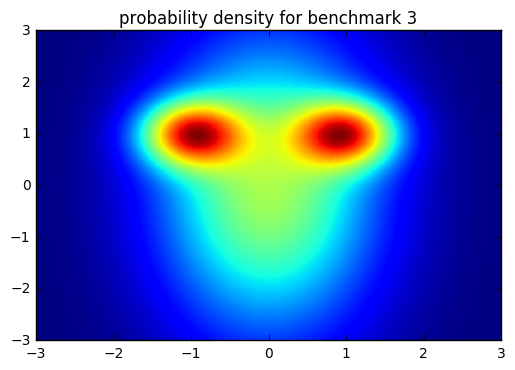

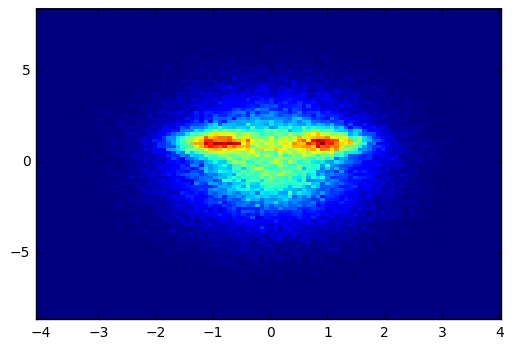

In [129]:
%matplotlib inline
from scipy.stats import multivariate_normal 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

class Mix2DNormalDist:
    """ Class to sammple data for a mixture of Normal distributions in one dimension
    and also provide a function of the underlying model """
    def __init__(self, means, covs, rel_fracs):
        self.means = means
        self.covs = covs
        self.rel_fracs = rel_fracs
    
    def data(self, samples, seed = 1):
        np.random.seed(1)
        normal = np.random.multivariate_normal
        normal_pars = zip(self.means, self.covs, self.rel_fracs)
        return np.concatenate(tuple(normal(m,c,int(np.rint(f*samples)))
                                    for m,c,f in normal_pars))
    def density(self, X):
        normal_pars = zip(self.means, self.covs, self.rel_fracs)
        return sum(tuple(f*multivariate_normal(m,c).pdf(X) for m,c,f in normal_pars))
      
b3 = Mix2DNormalDist([[0,0],[1,1],[-1,1]],
                     [[[1,0],[0,4]],[[0.2,0],[0,0.2]],[[0.2,0],[0,0.2]]],
                     [0.8,0.1,0.1])
b3_density_f, b3_density_ax = plt.subplots()
x, y = np.mgrid[-3:3:.01, -3:3:.01]
X_plot = np.empty(x.shape + (2,))
X_plot[:, :, 0] = x; X_plot[:, :, 1] = y
b3_density_ax.pcolormesh(x,y,b3.density(X_plot));

b3_hist_f, b3_hist_ax = plt.subplots()
b3_data = b3.data(100000)
b3_hist_ax.hist2d(b3_data[:,0], b3_data[:,1],100, normed=True);
b3_density_ax.set_title("probability density for benchmark 3");


#### Benchmark 3 - Multivariate Normal mixture (a.k.a. Alien density)

A 2D *pdf* is considered, using a mixture of three 2D normal distributions $\mathcal{N}(\mu, \Sigma)(\vec{x})$:
 * face: $\mu=(0,0)$ $\Sigma= \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$ $\rm{norm} = 0.8$
 * right eye: $\mu=(1,1)$ $\Sigma= \begin{pmatrix} 0.2 & 0 \\ 0 & 0.2 \end{pmatrix}$ $\rm{norm} = 0.1$
 * left eye: $\mu=(-1,1)$ $\Sigma= \begin{pmatrix} 0.2 & 0 \\ 0 & 0.2 \end{pmatrix}$ $\rm{norm} = 0.1$


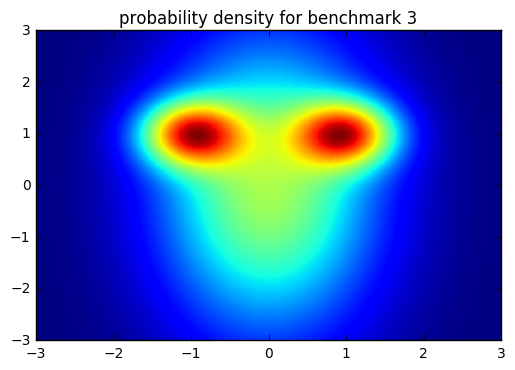

In [130]:
b3_density_f

### Bias, variance and loss functions

When dealing with non-parametric density estimation, typically there are
some parameters to tune which handle the balance between the bias of the estimation
and its variance (e.g. bin size for a histogram or bandwith for a fixed KDE).
To decide which parameter to use is important to decide in quantitative terms what
is a "good" density estimate, by defining a **loss function**. The most popular choice
as a loss function is the so called *mean integrated squared error* (MISE):
$$L(f,\hat{f}) = \int [\hat{f}(x)-f(x)]^2dx$$
which is nothing else but the integral of the *mean squared error* (MSE). It is
important to point out that other loss functions are possible as the 
integrated $L_1$ distance $\int |\hat{f}(x)-f(x)|dx$ or the average log-likelihood
ratio $\int f(x)\log{\frac{f(x)}{\hat{f}(x)}}dx$. For simplicity, in this study the
MISE will be used.

#### What if we do not know $f(x)$?

The real virtue of non-parametric methods it is that they work when $f(x)$ is not known,
however in the previous formulation of the MSE loss function $f(x)$ explicitly appears.
To estimate the MSE directly from data we can consider:
$$L(f,\hat{f}) = \int [\hat{f}(x)-f(x)]^2dx = \\  \int f^2(x)dx - 2\int \hat{f}(x)f(x)dx + \int \hat{f}^2(x)dx $$
where the first term is constant so do not matter for the optimization. The third term can
be obtained numerically using the density estimate. The second term can be approximated
by
$$-2\int \hat{f}(x)f(x)dx = \frac{2}{n} \sum_{i=1}^n \hat{f}(x) $$
however if we use the
same data to obtain $\hat{f}$ and estimate the expected loss this will lead to overfitting, so
we have to estimate the expected loss using cross-validation.


### Confidence intervals and bands

Another crucial aspect of non-parametric density estimates
is assesing the uncertainty of the density estimates. This
is specially important if we plan to use the density estimate
to do further inference. It is important to distinguish between
these two different but related concepts.
* **Pointwise CI/CB** is the confidence interval/band $\hat{f}(x)^{+u_p(x)}_{-d_p(x)}$ with
coverage probability $1-\alpha$ which satisfies for each value of x **separately**
$$P \left ( \hat{f}(x)-d_p(x) \leq \hat{f}(x) \leq \hat{f}(x)+u_p(x) \right )= 1-\alpha$$
* **Simultaneous CB** is the confidence band $\hat{f}(x)^{+u_s(x)}_{-d_s(x)}$ with coverage
probability $1-\alpha$ which satisfies for all $x$ in the domain of $f(x)$ **simultaneously**
$$P \left ( \hat{f}(x)-d_p(x) \leq \hat{f}(x) \leq \hat{f}(x)+u_p(x) \ \mathrm {for \ all} \ x \right )= 1-\alpha$$



#### How to obtain CI/CB for a density estimator

Depending on the type of the estimator, pointwise confidence intervals for
$f(x)$ be obtained directly (e.g. binomial CI for a histogram) or
estimated under certain approximations (e.g. asymptotic for fixed KDE).

Simultaneous confidence bands are typically wider and not straighforward
to obtain directly (i.e. Bonferroni correction can be an approximation for
histograms).

A more general, method independent approach is to use bootstrap and estimate
pointwise CI or simultaneous CB from the percentiles. It is important that
as a general rule both closed form and boostrap confidence intervals **neglect
density estimation bias**.


### Histograms as density estimators

If the whole sample $\{x_i\}_{i=1}^n$ is divided in $m$ bins, which will be
referred as $\{B_j\}_{j=1}^m$, each of them with a binwidth $h_j$.

If $y_j$ is the number of observations in $B_j$, consider $\hat{p}_j= y_j/n$
and $p_j=\int_{B_j} f(u)du$ as the observed and expected fraction of observations
in each bin. A histogram can be treated as a density estimator of a probability
density function considering:
$$\hat{f} = \frac{\hat{p}_j}{h_j}$$



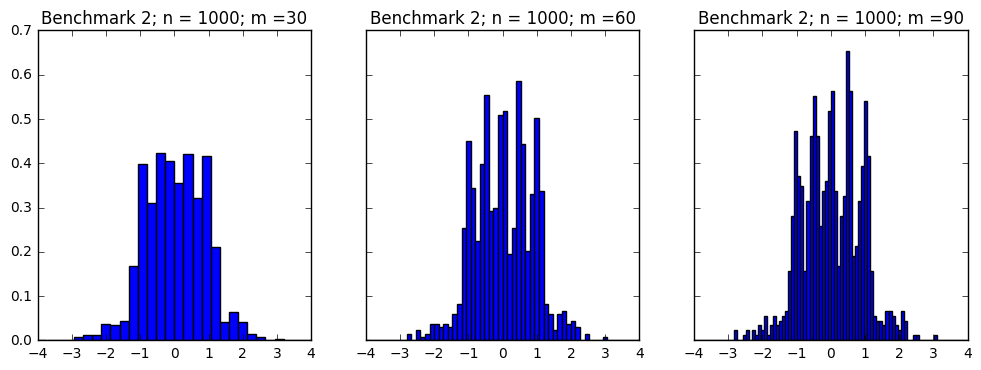

In [10]:
n_samples = 1000
b2_m_data = b2.data(n_samples)
b2_hist_h_f, b2_hist_h_ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
n_bins = [30,60,90]
for i in range(3):
    b2_hist_h_ax[i].hist(b2_m_data,n_bins[i], range=[-4,4], normed=True);
    b2_hist_h_ax[i].set_title("Benchmark 2; n = {}; m ={}".format(n_samples,n_bins[i]))

#### Smoothing parameters

In a equal-binwidth histogram, there are two free parameter on which the
density estimator will depend:
* **binwith** $h$: most important parameter, sets the balance between bias and variance
in the density estimation
* **bin origin**:  start position in $x$ of the first bin

In a variable-binwidth histogram, the width of each bin can be considered as a
parameter.


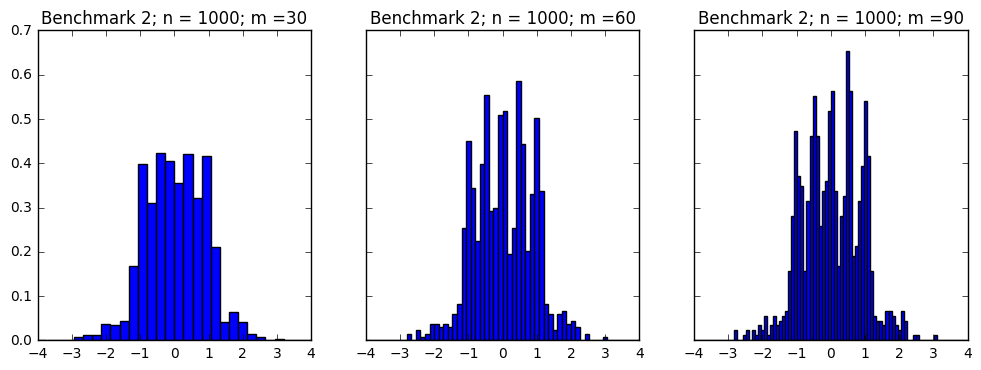

In [8]:
b2_hist_h_f

#### Are they really density estimators?

The expectation and variance of $\hat{f}(x)$ when using a histogram
are:
$$\mathop{\mathbb{E}} \hat{f}(x) =  \frac{p_j}{h_j}$$
$$\mathop{\mathbb{V}} \hat{f}(x) =  \frac{p_j(1-p_j)}{nh_j^2}$$
In a sense, histograms can be thought as a non-parametric density estimation.
In reality, it is only an unbiased estimator of the average density $p_j/h_j$ over
each bin, but a biased estimator of $f(x)$ in general. Bias can be alleviated
by undersmoothing.

#### Drawbacks of histograms

While is good enough for many applications (e.g. simple 1D and 2D visualizations
or binned likelihood fits), there are many issues regarding the use of a histogram
as density estimator:
* **Resulting density function $\hat{f}(x)$ is not smooth**. Indeed its derivatives
are 0 everywhere except in the bin transitions where they are $\infty$. For some
applications (e.g. clustering or unbinned MLE fit) this create discontinuites when
computing gradients.
* **Choice of bin origin**. Might affect significantly the resulting $\hat{f}(x)$.
* **Poor convergence rate of $\hat{f}(x)$ to $f(x)$ **. Other density estimators
scale much better with $n$ and have smaller bias.
* **Do not scale well to multiple dimensions**. Lack of statistics when binning
n-D space leads to unaccurate n-D density estimations.


### Nearest neighbor density estimation

Instead of fixing a region of space and counting the fraction of observations
which fall on it, when using nearest neighbor density estimation we consider
the $k$ nearest neighbor density estimate as:
$$\hat{f}(x) = \frac{k}{2nd_k(x)}$$
where $n$ is the sample size and $d_k(x)$ is the distance to the $k$ nearest
neighbor. 

The parameter $k$ controls the bias-variance trade-off. However, it is important
that the $\hat{f}(x)$ obtained by kNN is general no smooth and sensible to local
noise in the data. In addition, it has to be explicitly normalized.

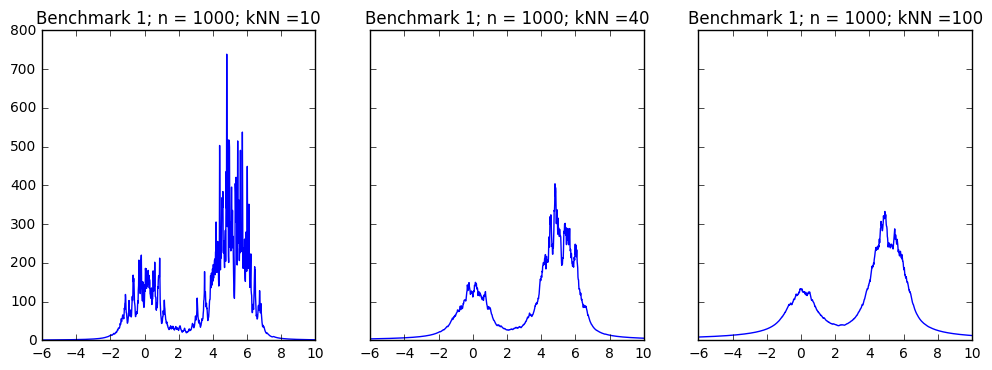

In [41]:
from astroML.density_estimation import KNeighborsDensity

n_samples = 1000
b1_m_data = b1.data(n_samples)
b1_nn_k_f, b1_nn_k_ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
n_ks = [10,40,100]
X_plot = np.linspace(-6,10,1000)[:,np.newaxis]
for i in range(3):
    knn = KNeighborsDensity('simple',n_ks[i])
    knn.fit(b1_m_data)
    b1_nn_k_ax[i].plot(X_plot, knn.eval(X_plot));
    b1_nn_k_ax[i].set_title("Benchmark 1; n = {}; kNN ={}".format(n_samples,n_ks[i]))

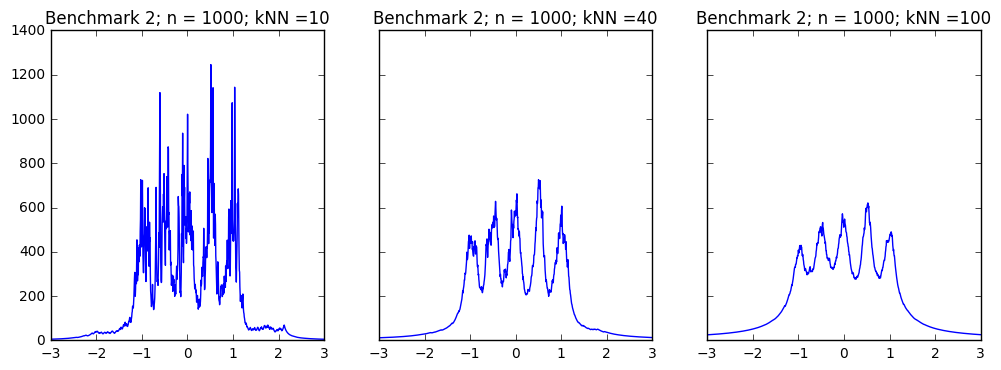

In [40]:
from astroML.density_estimation import KNeighborsDensity

n_samples = 1000
b2_m_data = b2.data(n_samples)
b2_nn_k_f, b2_nn_k_ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
n_ks = [10,40,100]
X_plot = np.linspace(-3,3,1000)[:,np.newaxis]
for i in range(3):
    knn = KNeighborsDensity('simple',n_ks[i])
    knn.fit(b2_m_data)
    b2_nn_k_ax[i].plot(X_plot, knn.eval(X_plot));
    b2_nn_k_ax[i].set_title("Benchmark 2; n = {}; kNN ={}".format(n_samples,n_ks[i]))

#### kNN density applied to the 1D benchmarks

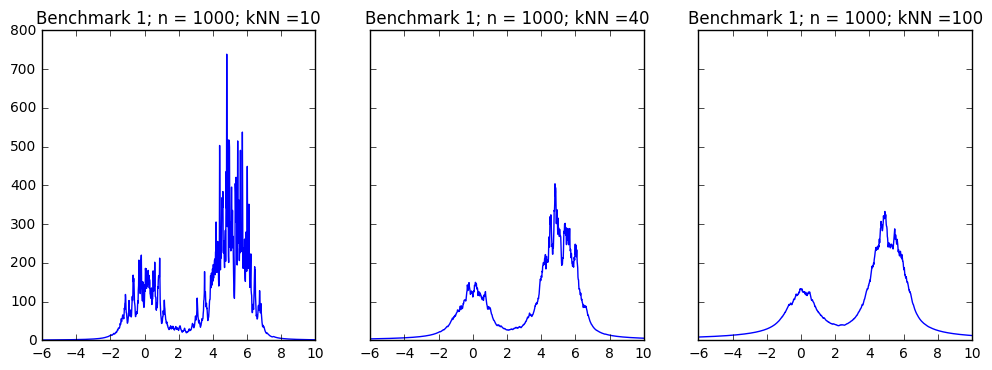

In [43]:
b1_nn_k_f

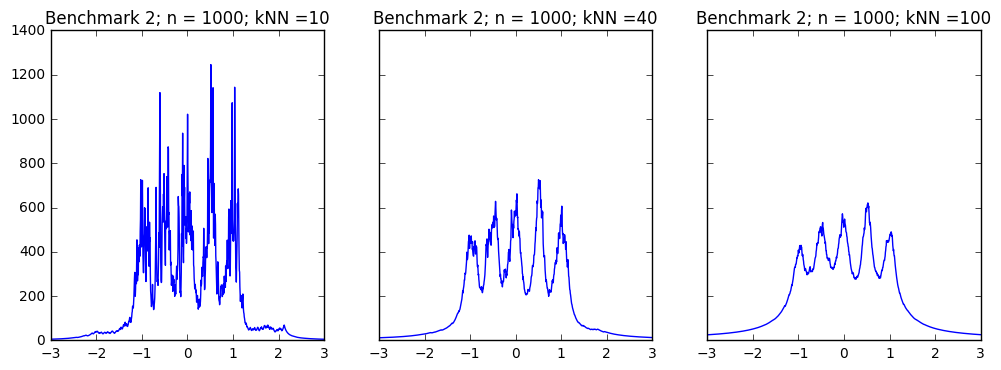

In [42]:
b2_nn_k_f

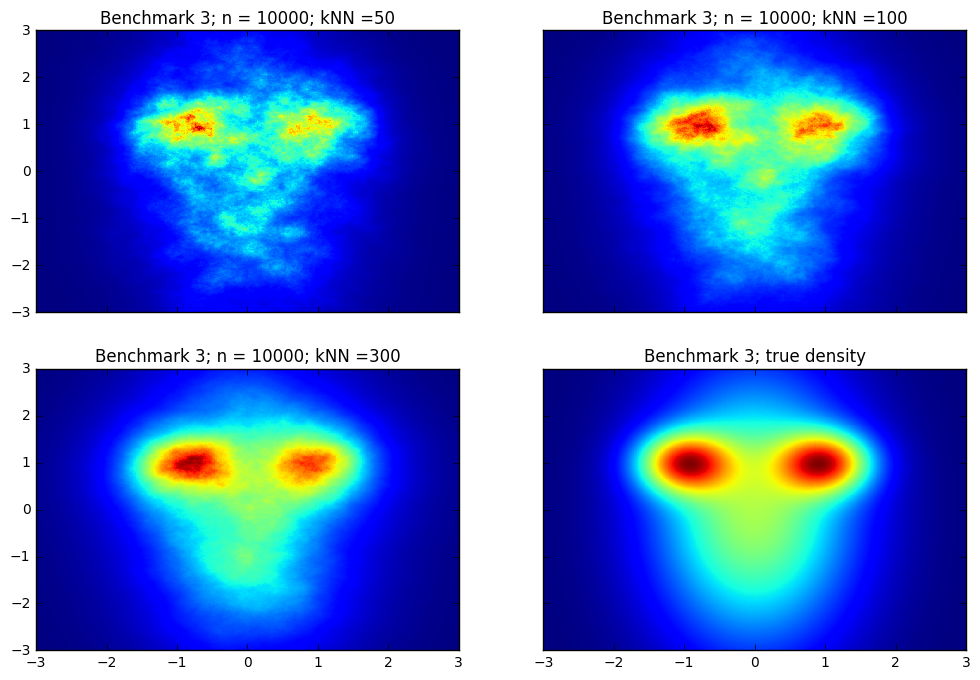

In [178]:
from astroML.density_estimation import KNeighborsDensity

n_samples = 10000
b3_m_data = b3.data(n_samples)
b3_nn_k_f, b3_nn_k_ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
b3_nn_k_ax = b3_nn_k_ax.flatten()
n_ks = [50,100,300]
x, y = np.mgrid[-3:3:.01, -3:3:.01]
X_plot = np.empty(x.shape + (2,))
X_plot[:, :, 0] = x; X_plot[:, :, 1] = y
b3_nn_k_ax[3].pcolormesh(x,y,b3.density(X_plot));
b3_nn_k_ax[3].set_title("Benchmark 3; true density")
Nx = 600
Ny = 600
xmin, xmax = (-3, 3)
ymin, ymax = (-3, 3)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T
for i in range(3):
    knn = KNeighborsDensity('simple',n_ks[i])
    knn.fit(b3_m_data)
    b3_nn_k_ax[i].pcolormesh(x,y, knn.eval(Xgrid).reshape((Nx, Ny)).T);
    b3_nn_k_ax[i].set_title("Benchmark 3; n = {}; kNN ={}".format(n_samples,n_ks[i]))

#### kNN alien visitation

We can apply kNN to n-D density but expect higher very noisy
density estimation $f(\vec{x})$ unless
really large statistics are available.

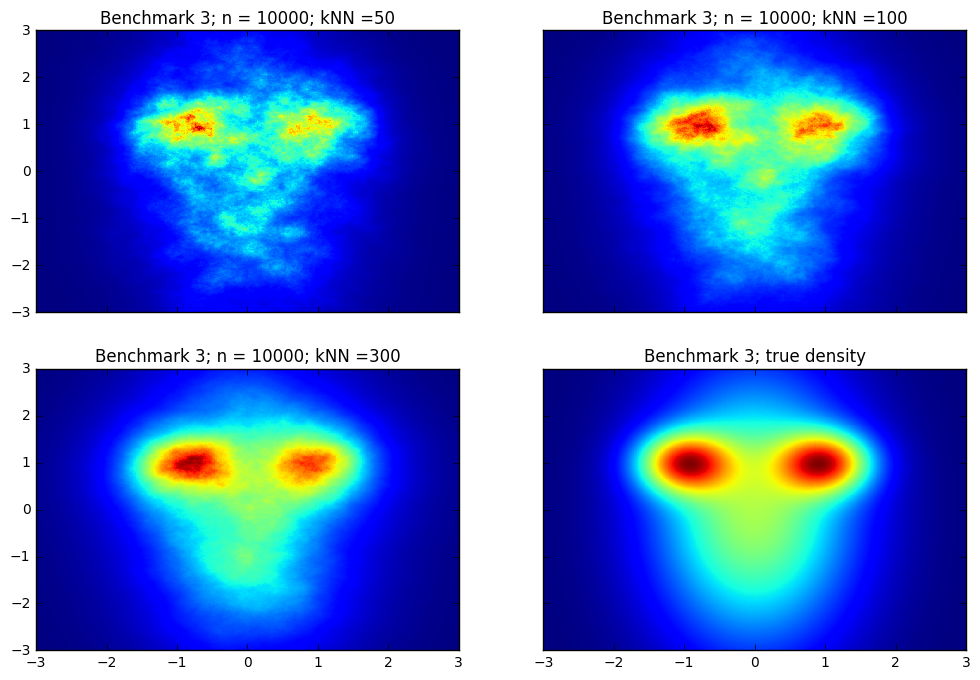

In [179]:
b3_nn_k_f

### Kernel density estimation

In addition to histograms and kNN, another conceptually simple
approach is possible. By placing a function $K$ (i.e. *kernel*) over
each sample point $\{x_i\}$ a density estimate can be constructed as:
$$\hat{f}(x) = \frac{1}{nh} \sum_{i=1}^n K \left ( \frac{x_i - x}{h} \right )$$
where h is the smoothing parameter, intuitively corresponding to the width of
the kernel function.

In order to get meaninful density estimates, $K$ has to verify the following
requirements:
* $K(u) = K (-u)$
* $\int K(u)du = 1$
* $\int u^2 K(u)du > 0$

but any function that verify those can be in principle used.


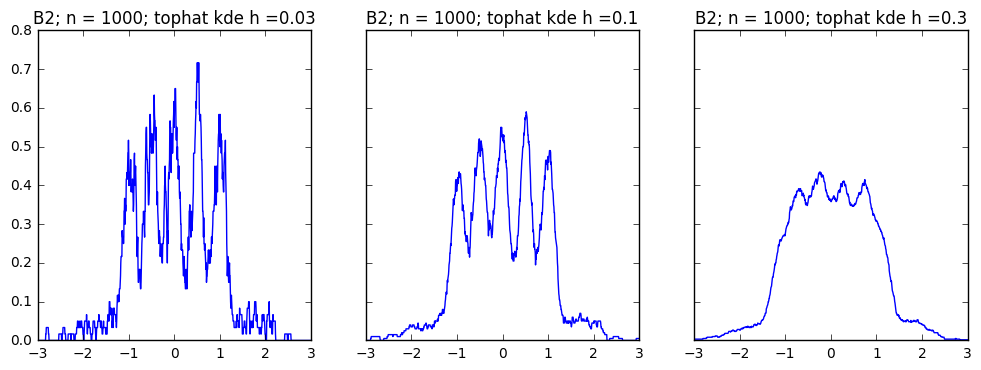

In [138]:
from sklearn.neighbors.kde import KernelDensity

n_samples = 1000
b2_m_data = b2.data(n_samples)
b2_kde_n_f, b2_kde_n_ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
bws = [0.03,0.10,0.3]
X_plot = np.linspace(-3,3,1000)[:,np.newaxis]
for i in range(3):
    kde =  KernelDensity(kernel='tophat',bandwidth=bws[i])
    kde.fit(b2_m_data)
    b2_kde_n_ax[i].plot(X_plot, np.exp(kde.score_samples(X_plot)));
    b2_kde_n_ax[i].set_title("B2; n = {}; tophat kde h ={}".format(n_samples,bws[i]))

#### The naivest kernel possible

The naivest kernel function could be a box of unit area of width $2h$ centered in $0$. This is called simple local neighborhood density or tophat kernel and already gives a decent density estimation if the bandwidth is properly tunned.

The lack of smoothness in the function seen for the histograms and kNN density
estimator still remains, so gradients and derivatives of the estimated density
are still not nice.

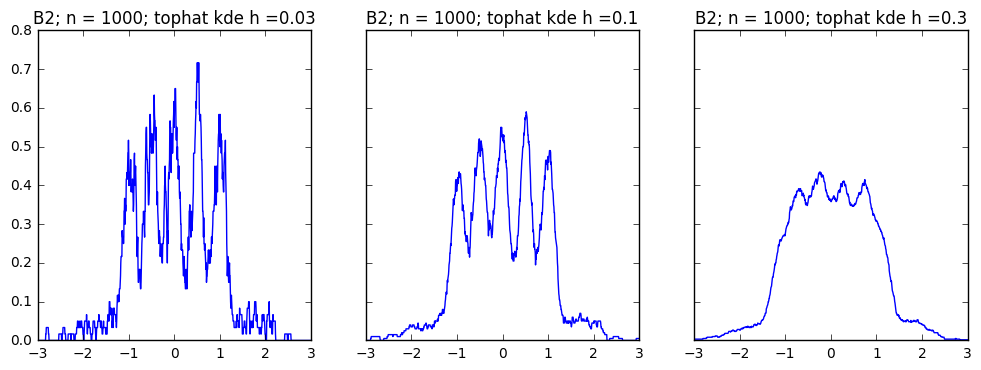

In [139]:
b2_kde_n_f

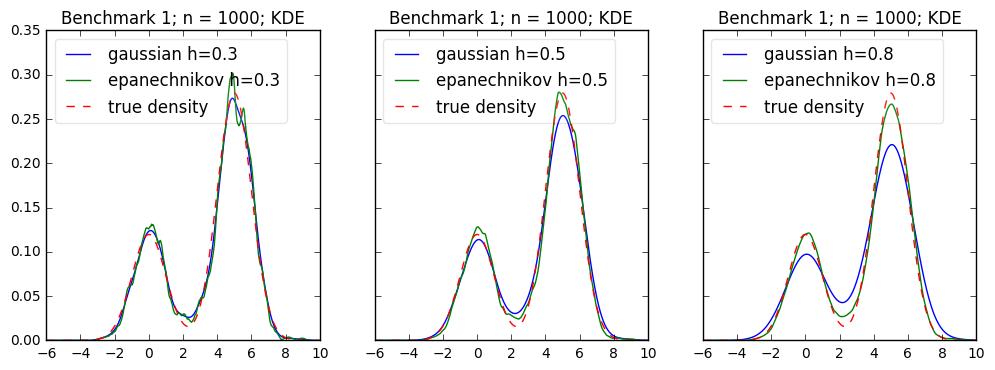

In [165]:
from sklearn.neighbors.kde import KernelDensity

n_samples = 1000
b1_m_data = b1.data(n_samples)
b1_kde_c_f, b1_kde_c_ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
bws = [0.3,0.5,0.8]
X_plot = np.linspace(-6,10,1000)[:,np.newaxis]
for i in range(3):
    kde_g =  KernelDensity(kernel='gaussian',bandwidth=bws[i])
    kde_g.fit(b1_m_data)
    b1_kde_c_ax[i].plot(X_plot, np.exp(kde_g.score_samples(X_plot)),
                        label="gaussian h={}".format(bws[i]));
    kde_e =  KernelDensity(kernel='epanechnikov',bandwidth=bws[i])
    kde_e.fit(b1_m_data)
    b1_kde_c_ax[i].plot(X_plot, np.exp(kde_e.score_samples(X_plot)),
                        label="epanechnikov h={}".format(bws[i]));
    b1_kde_c_ax[i].set_title("Benchmark 1; n = {}; KDE".format(n_samples))
    b1_kde_c_ax[i].plot(X_plot, b1.density(X_plot), "r--",
                       label="true density".format(bws[i]));
    b1_kde_c_ax[i].legend(loc='upper left',fancybox=True, framealpha=0.1)

#### Let's fix the bumpiness

Using a derivable and smooth function instead of the *tophat* kernel can fix the
smoothness problem seen in the previous case. A popular choice is using a unit Gaussian
kernel function, but also the Epanechnikov kernel is throughly used to have finite
tails:
$$
K(u) = \begin{cases} 
      \frac{3}{4} (1-u^2) & \mathrm{if} \ |u| \leq 1 \\
      0 & \mathrm{otherwise} 
   \end{cases}
$$

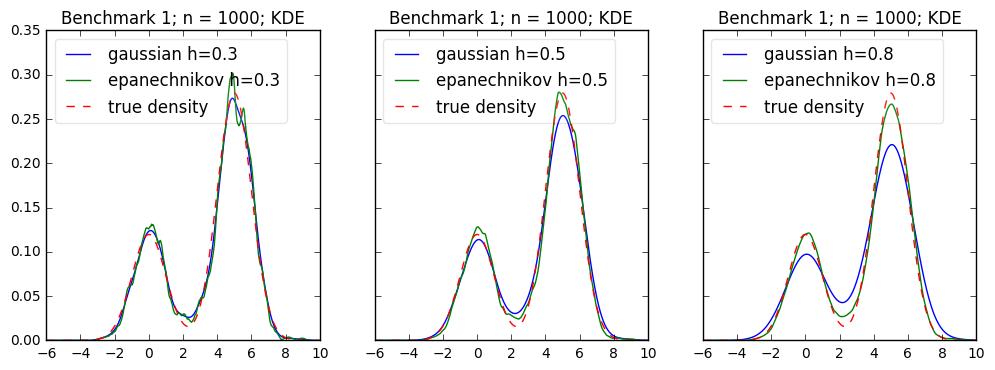

In [166]:
b1_kde_c_f

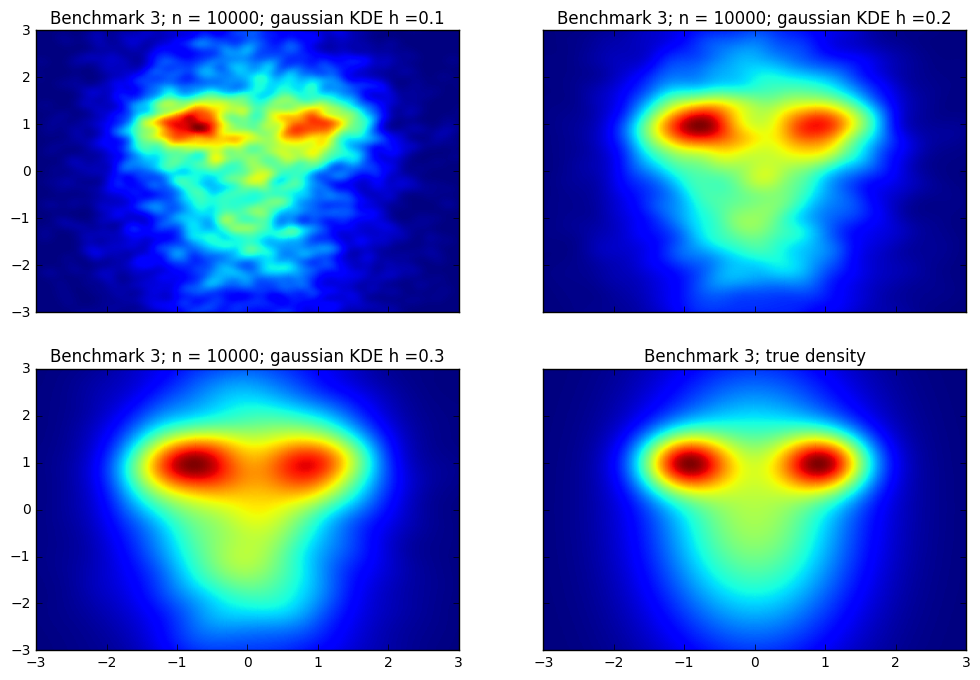

In [175]:
from sklearn.neighbors.kde import KernelDensity

n_samples = 10000
b3_m_data = b3.data(n_samples)
b3_kde_g_f, b3_kde_g_ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
b3_kde_g_ax = b3_kde_g_ax.flatten()
bws = [0.1,0.2,0.3]
x, y = np.mgrid[-3:3:.01, -3:3:.01]
X_plot = np.empty(x.shape + (2,))
X_plot[:, :, 0] = x; X_plot[:, :, 1] = y
b3_kde_g_ax[3].pcolormesh(x,y,b3.density(X_plot));
b3_kde_g_ax[3].set_title("Benchmark 3; true density")
Nx = 600
Ny = 600
xmin, xmax = (-3, 3)
ymin, ymax = (-3, 3)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T
for i in range(3):
    kde = KernelDensity(kernel='gaussian',bandwidth=bws[i])
    kde.fit(b3_m_data)
    b3_kde_g_ax[i].pcolormesh(x,y, np.exp(kde.score_samples(Xgrid).reshape((Nx, Ny)).T));
    b3_kde_g_ax[i].set_title("Benchmark 3; n = {}; gaussian KDE h ={}".format(n_samples,bws[i]))

#### Extraterrestial kernel density

As with previous method, this can also be applied in a n-D space with the same drawbacks. Nevertheless, the smoothness of 2D gaussian-kernel KDE should make our alien happy. 

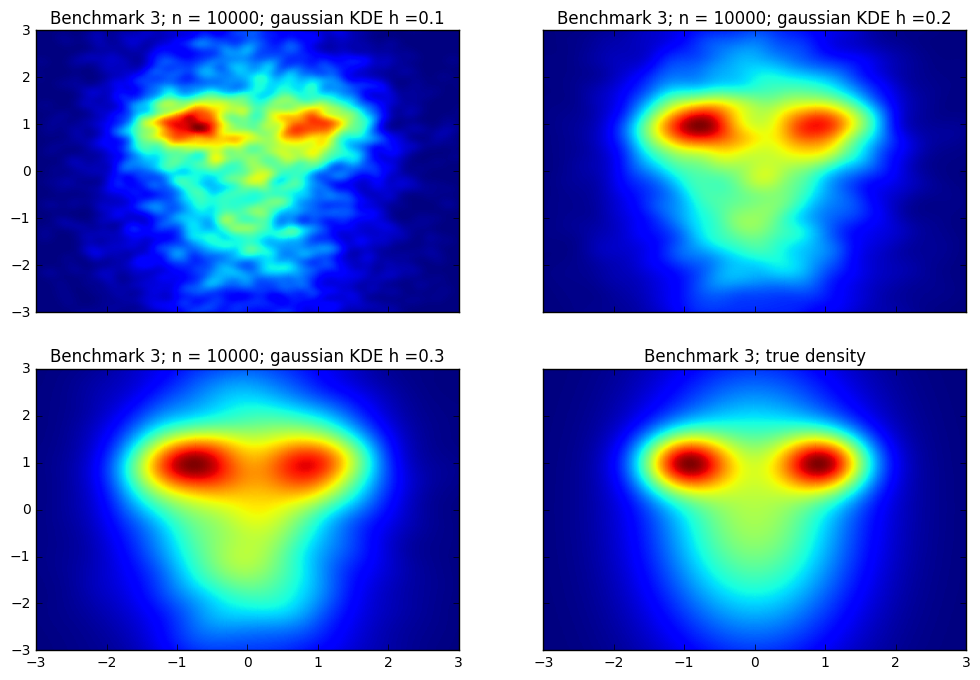

In [176]:
b3_kde_g_f

In [90]:
from scipy.integrate import trapz
from sklearn.neighbors.kde import KernelDensity

class MiseScorer1D():
    """ Class obtain the numerically approximated MISE from a density estimator,
        numerical integral is obtained numerically using trapezoidal rule"""
    def __init__(self, int_ranges, n_points):
        self.int_ranges = int_ranges
        self.n_points = n_points
        
    def eval_scorer(self,estimator, X, y):
        lower, upper = self.int_ranges[0],self.int_ranges[0]
        x_vals = np.linspace(lower, upper, self.n_points, endpoint = True )[:,np.newaxis]
        f2 = estimator.eval(X)**2
        sum_f = np.sum(estimator.eval(X))
        int_f2 = trapz(f2,x_vals)  
        return -2*sum_f/n + int_f2
    
    def scorer(self,estimator, X, y=None):
        lower, upper = self.int_ranges[0],self.int_ranges[1]
        x_vals = np.linspace(lower, upper, self.n_points, endpoint = True)[:,np.newaxis]
        f2 = np.exp(estimator.score_samples(x_vals))**2
        sum_f = np.sum(np.exp(estimator.score_samples(X)))
        int_f2 = trapz(f2,x_vals[:,0])
        return -2*sum_f/X.shape[0] + int_f2
    
    

n_samples = 1000
b1_m_data = b1.data(n_samples)
kde = KernelDensity(kernel='gaussian',bandwidth=0.01)
kde.fit(b1_m_data)

mise = MiseScorer1D([-10,10],1000)
mise.scorer(kde, b1_m_data, None)

-0.22466812452724316

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors.kde import KernelDensity


cv = 10
param_grid = [
  {'bandwidth': np.linspace(0.1,1.0, 19,endpoint = True), 'kernel': ['gaussian']}
]

n_samples = 1000
b1_m_data = b1.data(n_samples)
mise = MiseScorer1D([-10,10],1000)
clf = GridSearchCV(KernelDensity(), param_grid, scoring = mise.scorer, cv=10 )
clf.fit(b1_m_data);

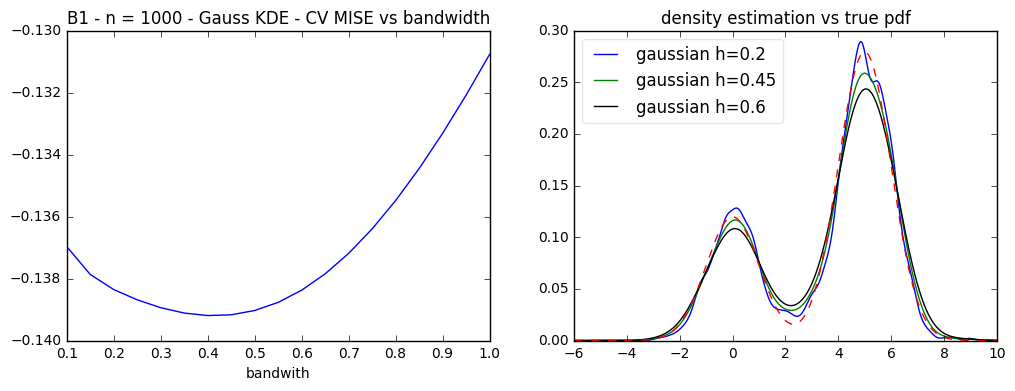

In [121]:

cv_mise_f, cv_mise_ax = plt.subplots(1,2, figsize=(12,4))
mean_cv_mise = clf.cv_results_['mean_test_score']
std_cv_mise = clf.cv_results_['std_test_score']/np.sqrt(10)
bandwidths = [p["bandwidth"] for p in  clf.cv_results_['params']]

cv_mise_ax[0].errorbar(bandwidths,mean_cv_mise)
cv_mise_ax[0].set_title("B1 - n = {} - Gauss KDE - CV MISE vs bandwidth".format(n_samples))
cv_mise_ax[0].set_xlabel("bandwith")

X_plot = np.linspace(-6,10,1000)[:,np.newaxis]


bws = [0.2, 0.45, 0.6]
cols = ["b-","g-","k-"]
for i in range(3):
    kde = KernelDensity(kernel="gaussian", bandwidth=bws[i])
    kde.fit(b1_m_data)
    cv_mise_ax[1].plot(X_plot, np.exp(kde.score_samples(X_plot)),cols[i],
                        label="gaussian h={}".format(bws[i]));
cv_mise_ax[1].plot(X_plot, b1.density(X_plot), "r--")
cv_mise_ax[1].set_title("density estimation vs true pdf")
cv_mise_ax[1].legend(loc='upper left',fancybox=True, framealpha=0.1);


#### Chosing optimal bandwidth

While there are closed form expressions which provide an asymtotic approximation
to find the optimal bandwidth, we are going to used the generic CV-based MISE presented before (i.e. applicable to any $\hat{f}(x)$ indepently of the density estimation method):

$$CV \ MISE \approx   \int \hat{f}^2_{\mathrm{CV}}(x)dx- \frac{2}{n} \sum_{i=1}^{n_{\mathrm{CV}}} \hat{f}_{\mathrm{CV}}(x) $$

This is evaluated in cross-validation splits (10 in the example below) to obtain the mean CV MISE. The optimal bandwidth corresponds with the minimum found.

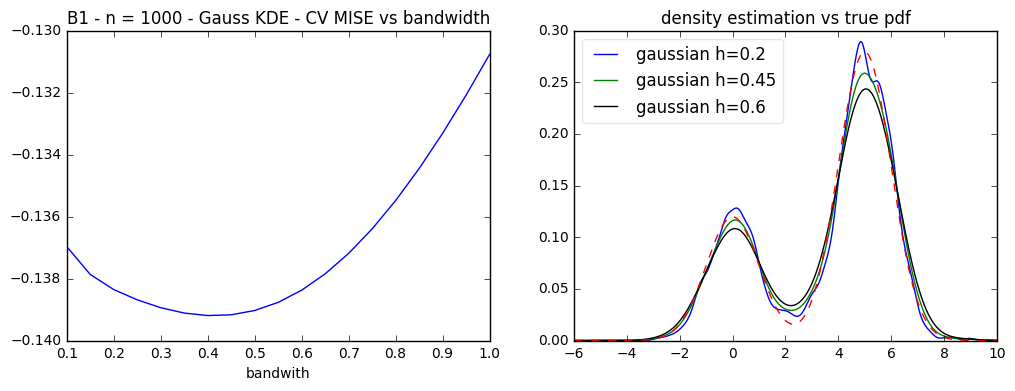

In [123]:
cv_mise_f

In [202]:
from sklearn.neighbors.kde import KernelDensity


X_plot = np.linspace(-6,10,1000)[:,np.newaxis]


n_samples = 1000
b1_m_data = b1.data(n_samples)

np.random.seed(7)
n_boostraps = 500

data_boot = np.zeros((X_plot.shape[0],n_boostraps))
for n_b in range(n_boostraps):
    kde = KernelDensity(kernel='gaussian',bandwidth=0.2)
    kde.fit(np.random.choice(b1_m_data[:,0],b1_m_data.shape,replace=True))
    data_boot[:, n_b] = np.exp(kde.score_samples(X_plot))

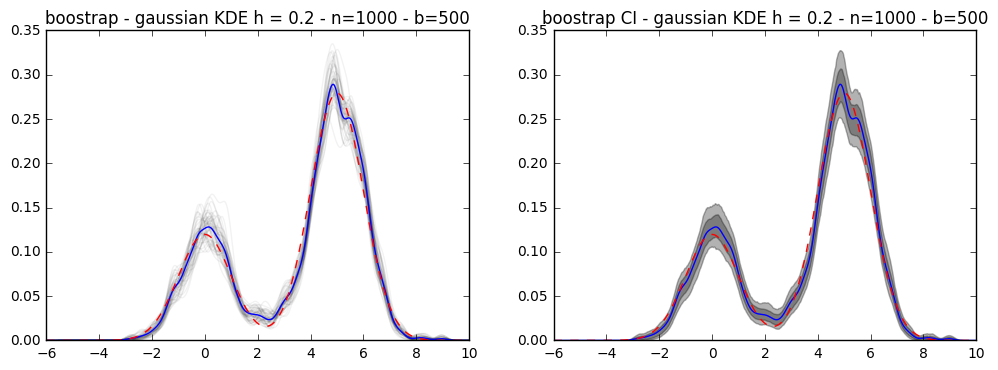

In [221]:


b1_boot_f, b1_boot_ax = plt.subplots(1,2, figsize=(12,4))

p_2sigma = [np.percentile(data_boot,97.5,axis=1), np.percentile(data_boot,2.5,axis=1)]
p_1sigma = [np.percentile(data_boot,84.0,axis=1), np.percentile(data_boot,16.0,axis=1)]

kde = KernelDensity(kernel='gaussian',bandwidth=0.2)
kde.fit(b1_m_data)

for n_b in range(n_boostraps):
    n_boostraps = 50
    b1_boot_ax[0].plot(X_plot, data_boot[:, n_b],'k-', alpha=0.05)

b1_boot_ax[0].plot(X_plot,  np.exp(kde.score_samples(X_plot)),'b-', alpha = 1)
b1_boot_ax[0].plot(X_plot,  b1.density(X_plot),'r--', alpha = 1)
b1_boot_ax[0].set_title("boostrap - gaussian KDE h = 0.2 - n=1000 - b=500")
b1_boot_ax[1].fill_between(X_plot[:,0],p_2sigma[0],p_2sigma[1],facecolor='black', alpha=0.3)
b1_boot_ax[1].fill_between(X_plot[:,0],p_1sigma[0],p_1sigma[1],facecolor='black', alpha=0.3)
b1_boot_ax[1].plot(X_plot,  np.exp(kde.score_samples(X_plot)),'b-', alpha = 1)
b1_boot_ax[1].plot(X_plot,  b1.density(X_plot),'r--', alpha = 1)
b1_boot_ax[1].set_title("boostrap CI - gaussian KDE h = 0.2 - n=1000 - b=500");

#### Boostrap CI for density estimation

At the beginning it was stated that the variability of the density estimation
$\hat{f}(x)$ can be assesed using bootstrapping. This can generally be applied
to any density estimation method but we will consider the previous gaussian KDE
example.

We sample $b$ times $n$ samples with replacement from the originaldata and
obtain the density estimators for each bootstrap subsample $\hat{f_l}(x)$ which
are shown our example in the left plot. Then, asumming gaussianity under certain
transformation, we can get boostrap confidence intervals at from the percentiles.

**Remember that bias is not easy to estimate, so undersmoothed density estimators
are always preferred (that why h=0.2 is used), coverage is not guaranteed in presence
of non-negligible bias.**


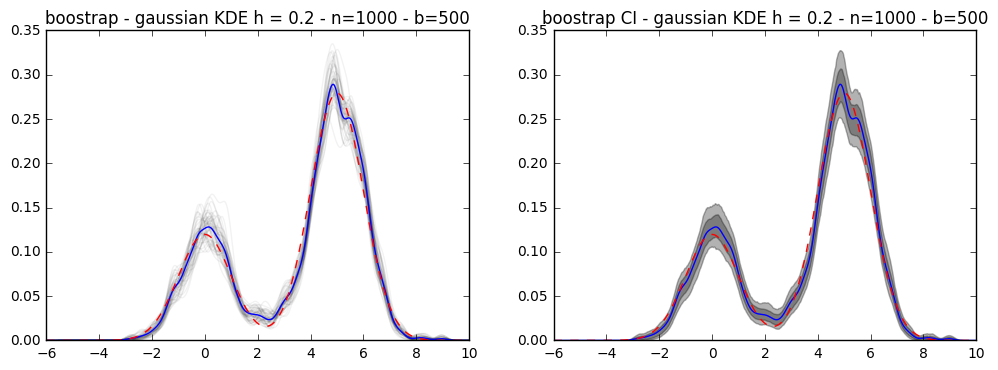

In [222]:
b1_boot_f

### Additional interesting stuff on density estimation

The topics that were covered here are just a (small) subset of the methods
and particularities on the broad statistical field of density estimation. There
are a lot of cool stuff I did not the time to play with, some examples:
* [Average shifted histogram (ASH)](Averaged-shifted-histogram)
* [Mixture models](#Mixture-models)
* [Adaptative kernel density estimation](#Adaptative-kernel-density-estimation)


#### Averaged shifted histogram

Obtained by averaging over histograms with different bin origins. 
It has better convergence to $f(x)$than histograms and similar 
computational cost. It was introduced by [Chamayou (1980)](http://www.sciencedirect.com/science/article/pii/0010465580900375)
for the analysis of HEP data.

![Average Shifted Histogram (ASH) vs standard histogram](ash_example.png)


#### Mixture models

It is a semiparametric density estimation, a compact density estimation is
created by combining $C$ parametric components (e.g. Gaussians). In the limit $C\rightarrow\infty$
it is a universal approximator and therefore a fully non-parametric method.

Resort to numerical procedures for fitting, most used algoritm is
Expectation-Maximization (EM). In a way, they are a hybrid between parametric
and Kernel methods.

![Parametric, mixtures and kernel methods](mixture_models.png)



#### Adaptative kernel density estimation

[Variable/adaptative kernel estimation](http://projecteuclid.org/download/pdf_1/euclid.aos/1176348768) 
is based on modifying the kernel size based on the location of the samples $\{x_i\}$ and/or the location
of the test point $f(x)$.

Some versions of this type of density estimators can be though of mixture of nearest neighbors
and kernel density because the kernel size depend on the local density. They typically outperform
fixed kernel kernel density in multi-dimensional problems (see article above).

### Conclusions

There are many problems the underlying probability density function $f(x)$ is not
known or cannot be expressed parametricaly. Non-parametric density estimation methods
try to providing an estimation for $f(x)$ with as few assumptions as possible.

While histograms are asiduosly used for density estimation, they are biased estimators
of $f(x)$ given their piecewise nature, specially in the oversmoothing regime. In addition
they are no smooth and do not scale well in n-D problems.

Alternatives to histogram do exist, as the k nearest neighbor (kNN) estimator
and the kernel density estimator (KDE), which typically provide better convergence
at some additional computational cost.

When dealing with bias-variance trade-off on non-parametric density estimation,
not bad idea to go for undersmoothing (more variance) because is easier to estimate
based on the data direcly.

The use of advanced non-parametric methods (i.e. not histograms) in high energy
physics is not very popular but they might be useful in several use cases.





